# Реализация QuartzNet

Для выполнения данного ноутбука нужно иметь распакованный LJSpeech-1.1 на гугл диске<br>
Подтянем все зависимости

In [1]:
!pip install torchaudio

In [2]:
!pip install wandb

In [3]:
import torch
import torchaudio
import pandas as pd
import multiprocessing as mp
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import files

# %pylab inline
# from itertools import islice
# from scipy.signal import hann
# from scipy.io import wavfile


подключим логгер

In [4]:
import wandb
!wandb login 32f7df3c332802b239b3a621db53985fe17d319e
wandb.init(project="quartznet-implementation")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: maxthehuman (use `wandb login --relogin` to force relogin)


Подключим диск

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Будем использовать гпу

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# mp.set_start_method('fork', True)
# mp.set_start_method('spawn', True)

cuda


Конфиг

In [7]:
# path_to_dataset = "../resources/LJSpeech-1.1/"
path_to_dataset = "drive/My Drive/LJSpeech-1.1/"
path_to_metadata = path_to_dataset + "metadata.csv"
path_to_model = "drive/My Drive/ASR/model.pt"
path_to_weights_dict = "drive/My Drive/ASR/state_dict_model.pt"

batch_size = 32
epochs = 200
n_mels = 64
B = 3
R = 5

freq_mask_param = 15
time_mask_param = 25

column_names = ['wav_filename', 'text_with_numbers', 'text_in_letters'] 
max_str_len = 100

В датасете есть записи с не-ASCII символами (например, французские буквы), уберём их для простоты

In [9]:
def filter_non_ascii(string):
    try:
        str(string).encode('ascii')
    except UnicodeEncodeError:
        return False

    return True

Загружаем метаинформацию о датасете

In [10]:
LJdata = pd.read_csv(path_to_metadata, sep='|', names=column_names, header=None)
LJdata.drop(columns=['text_with_numbers'], inplace=True)
LJdata['text_in_letters'] = LJdata['text_in_letters'].apply(lambda x: str(x))
LJdata = LJdata[LJdata['text_in_letters'].apply(lambda x: len(x) <= max_str_len)]
LJdata = LJdata[LJdata['text_in_letters'].apply(filter_non_ascii)]

In [11]:
LJdata = LJdata[0:32*100]

In [12]:
LJdata

,wav_filename,text_in_letters
1,LJ001-0002,in being comparatively modern.
3,LJ001-0004,"produced the block books, which were the immed..."
5,LJ001-0006,"And it is worth mention in passing that, as an..."
7,LJ001-0008,has never been surpassed.
10,LJ001-0011,it is of the first importance that the letter ...
...,...,...
6526,LJ023-0073,The Court claimed the power to declare it unco...
6527,LJ023-0074,But a little later the Court itself admitted
6530,LJ023-0077,"by which any law is passed,"
6532,LJ023-0079,But since the rise of the modern movement for ...


In [13]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=n_mels).to(device)

In [14]:
class MyDataset(Dataset):
    def __init__(self, data):
        super(MyDataset, self).__init__()
        self._data = data

    def __getitem__(self, index: int):
        wav_filename, text_in_letters = self._data.iloc[index]
        path_to_file = path_to_dataset + "wavs/" + wav_filename + ".wav"

        waveform, sample_rate = torchaudio.load(path_to_file)
        waveform = waveform.to(device)
        spectrogram = mel_transform(waveform)
        spectrogram = torch.log(spectrogram + 1e-9)

        return spectrogram, text_in_letters , spectrogram.shape[0] // 2, len(text_in_letters)

    def __len__(self):
        return len(self._data)

In [15]:
my_dataset = MyDataset(LJdata)

код ниже нужно выполнить два раза, на первый раз отваливается из-за диска

3200
in being comparatively modern.
30
0


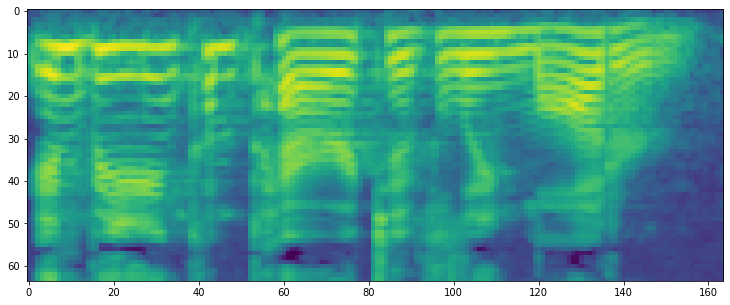

In [16]:
spec, lbl, spec_len, lbl_len = my_dataset.__getitem__(0)
spec = spec.cpu()
print(len(my_dataset))
print(lbl)
print(lbl_len)
print(spec_len)

plt.figure(figsize=(20, 5))
plt.imshow(spec.squeeze())
plt.show()

In [17]:
dataset_length = len(my_dataset)
train_dataset_length = int(dataset_length * 0.95)
test_dataset_length = dataset_length - train_dataset_length

train_dataset, test_dataset = random_split(
    dataset=my_dataset,
    lengths=[train_dataset_length, test_dataset_length],
    generator=torch.Generator().manual_seed(21)
)

print("train set size:", train_dataset_length, "\ntest set size:", test_dataset_length)

train set size: 3040 
test set size: 160


In [18]:
def augment(waveform):
    freq_transform = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    time_transform = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    return time_transform(freq_transform(waveform))

In [19]:
char2int = {
        '#': 0,
        ' ': 1,
        'a': 2,
        'b': 3,
        'c': 4,
        'd': 5,
        'e': 6,
        'f': 7,
        'g': 8,
        'h': 9,
        'i': 10,
        'j': 11,
        'k': 12,
        'l': 13,
        'm': 14,
        'n': 15,
        'o': 16,
        'p': 17,
        'q': 18,
        'r': 19,
        's': 20,
        't': 21,
        'u': 22,
        'v': 23,
        'w': 24,
        'x': 25,
        'y': 26,
        'z': 27
    }

int2char = {
        0: '#',
        1: ' ',
        2: 'a',
        3: 'b',
        4: 'c',
        5: 'd',
        6: 'e',
        7: 'f',
        8: 'g',
        9: 'h',
        10: 'i',
        11: 'j',
        12: 'k',
        13: 'l',
        14: 'm',
        15: 'n',
        16: 'o',
        17: 'p',
        18: 'q',
        19: 'r',
        20: 's',
        21: 't',
        22: 'u',
        23: 'v',
        24: 'w',
        25: 'x',
        26: 'y',
        27: 'z'
    }    

In [20]:
def text_transform(text_in_letters):
    int_array = []
    for c in text_in_letters:
        if c in char2int:
            int_array.append(char2int[c])
        
    return int_array

In [21]:
def collate_sequences(batch, is_test = False):
    specs = []
    labels = []
    specs_len = []
    labels_len = []
    for (log_mel_spec, text_in_letters, spec_len, text_len) in batch:
        # if not is_test:
        #     log_mel_spec = augment(log_mel_spec)
        specs.append(log_mel_spec.squeeze(0).transpose(0, 1))
        specs_len.append(log_mel_spec.shape[-1]//2)
        # print(log_mel_spec.shape)
        text_in_ints = torch.Tensor(text_transform(text_in_letters))
        labels.append(text_in_ints)
        labels_len.append(len(text_in_ints))

    specs = nn.utils.rnn.pad_sequence(sequences=specs, batch_first=True).transpose(1, 2)
    labels = nn.utils.rnn.pad_sequence(sequences=labels, batch_first=True)

    return specs, labels, specs_len, labels_len

In [22]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            collate_fn=collate_sequences,
            num_workers=0
            # pin_memory=True
        )

test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            collate_fn=lambda x: collate_sequences(x, True),
            num_workers=0
            # pin_memory=True
        )

In [ ]:
# mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

for i, (log_mel_spec, text_in_ints, spec_len, lbl_len) in enumerate(train_dataloader):
    if (i % 1 == 0):
        print(i)
        print(log_mel_spec.shape)
        print(spec_len, lbl_len)
        # plt.figure(figsize=(20, 5))
        # plt.imshow(log_mel_spec[0].squeeze())
        # plt.show()


In [23]:
class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride = 1):
        super(Conv_BN_ReLU, self).__init__()
        
        self.cnn = nn.Conv1d(
            in_channels, out_channels, kernel, stride=stride, padding=kernel//2
        )
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(
            num_features=out_channels
        )
        self.relu = nn.ReLU(inplace = False)

    def forward(self, x):
        x = self.cnn(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [24]:
class TCSConv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(TCSConv_BN_ReLU, self).__init__()

        self.depthwise_conv = nn.Conv1d(
            in_channels, in_channels, kernel_size=kernel, padding=kernel//2,
            groups=4, bias=False
        )
        self.pointwise_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, padding=0, bias=False
        )
        self.batch_norm = nn.modules.batchnorm.BatchNorm1d(
            num_features=out_channels
        )
        self.relu = nn.ReLU(inplace = False)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x  # (batch, channel, feature, time)

In [ ]:
print("R =", R)
print("B =", B)

R = 5
B = 3


In [25]:
class TCSBlock(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, in_channels, out_channels, kernel):
        super(TCSBlock, self).__init__()
        
        self.TCS_layers = nn.Sequential(*[
            TCSConv_BN_ReLU(in_channels, out_channels, kernel)
            for i in range(R)
        ])
        # self.TCS_layer_1 = TCSConv_BN_ReLU(in_channels=256, out_channels=256, kernel=33)
        # self.TCS_layer_2 = TCSConv_BN_ReLU(in_channels=256, out_channels=256, kernel=39)
        # self.TCS_layer_3 = TCSConv_BN_ReLU(in_channels=256, out_channels=512, kernel=51)
        # self.TCS_layer_4 = TCSConv_BN_ReLU(in_channels=512, out_channels=512, kernel=63)
        # self.TCS_layer_5 = TCSConv_BN_ReLU(in_channels=512, out_channels=512, kernel=75)
        
    def forward(self, x):
        x_copy = x
        x = self.TCS_layers(x)
        # x = TCS_layer_1(x)
        # x = TCS_layer_2(x)
        # x = TCS_layer_3(x)
        # x = TCS_layer_4(x)
        # x = TCS_layer_5(x)
        x += x_copy
        return x  # (batch, channel, feature, time)

In [26]:
class MainBlock(nn.Module):
    def __init__(self):
        super(MainBlock, self).__init__()
        
        self.TCSBlock_1 = TCSBlock(in_channels=256, out_channels=256, kernel=33)
        self.TCSBlock_2 = TCSBlock(in_channels=256, out_channels=256, kernel=39)
        self.helper_2_3 = Conv_BN_ReLU(in_channels=256, out_channels=512, kernel=51)
        self.TCSBlock_3 = TCSBlock(in_channels=512, out_channels=512, kernel=51)
        self.TCSBlock_4 = TCSBlock(in_channels=512, out_channels=512, kernel=63)
        self.TCSBlock_5 = TCSBlock(in_channels=512, out_channels=512, kernel=75)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = self.TCSBlock_1(x)
        x = self.TCSBlock_2(x)
        x = self.helper_2_3(x)
        x = self.TCSBlock_3(x)
        x = self.TCSBlock_4(x)
        x = self.TCSBlock_5(x)
        return x  # (batch, channel, feature, time)

In [27]:
class ASR(nn.Module):
    def __init__(self):
        super(ASR, self).__init__()
        
        self.conv_bn_relu_1 = Conv_BN_ReLU(
            in_channels=64, out_channels=256, kernel=33, stride=2
        )
        self.main_block = MainBlock()
        self.conv_bn_relu_2 = Conv_BN_ReLU(in_channels=512, out_channels=512, kernel=87)
        self.conv_bn_relu_3 = Conv_BN_ReLU(in_channels=512, out_channels=1024, kernel=1)
        self.conv_bn_relu_4 = nn.Conv1d(in_channels=1024, out_channels=len(char2int), kernel_size=1, padding=0, dilation=2, bias=False)
    
    def forward(self, x):
        # x (batch, channel, feature, time)
        x = self.conv_bn_relu_1(x)
        x = self.main_block(x)
        x = self.conv_bn_relu_2(x)
        x = self.conv_bn_relu_3(x)
        x = self.conv_bn_relu_4(x)
        x = x.transpose(1, 2)
        return x  # (batch, channel, feature, time)

In [28]:
model=ASR().to(device)
wandb.watch(model)

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [30]:
criterion = nn.CTCLoss(blank=0).to(device)

In [31]:
log_softmax = nn.LogSoftmax(dim=2)

In [ ]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

3040
160


In [32]:
def int_to_letters(text_in_ints):
    string = []
    for i in text_in_ints:
        string.append(int2char[i])
    return ''.join(string)


In [33]:
def Decoder(output, labels, label_lengths, blank_label=0, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(int_to_letters(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(int_to_letters(decode))
    return decodes, targets

In [34]:
!pip install python-Levenshtein

In [35]:
import Levenshtein

In [36]:
def wer(reference, hypothesis, delimiter=' '):

    reference = reference.lower()
    hypothesis = hypothesis.lower()

    # ref_words = reference.split(delimiter)
    # hyp_words = hypothesis.split(delimiter)

    # print("ref:\n", reference, "\nhyp:\n", hypothesis)
    edit_distance = Levenshtein.distance(reference, hypothesis)

    wer = float(edit_distance) / len(reference)
    return wer

In [37]:
def cer(reference, hypothesis, remove_space=False):

    reference = reference.lower()
    hypothesis = hypothesis.lower()
    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = Levenshtein.distance(reference, hypothesis)

    cer = float(edit_distance) / len(reference)
    return cer

In [38]:
def train(model, train_dataloader, criterion, optimizer, epoch):
    model.train()
    data_len = len(train_dataloader.dataset)
    #print(data_len)
    losses = []
    for batch_idx, (log_mel_specs, texts_in_ints, spec_lengths, lbl_lengths) in enumerate(train_dataloader):
        log_mel_specs = log_mel_specs.to(device)
        texts_in_ints = texts_in_ints.to(device)

        optimizer.zero_grad()

        output = model(log_mel_specs)  # (batch, time, n_class)
        #print(output.shape)
        #print(output)
        output = log_softmax(output)
        #print(output.shape)
        #print(output)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, texts_in_ints, spec_lengths, lbl_lengths)
        loss.backward()
        losses.append(loss)

        optimizer.step()
        if batch_idx == 1 and epoch % 10 == 1:
            decodes, targets = Decoder(
                output.transpose(0, 1), texts_in_ints, lbl_lengths, blank_label=0, collapse_repeated=True
            )
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(log_mel_specs), data_len,
                100. * batch_idx / len(train_dataloader), loss.item()))
            print("Decodes:\n", decodes)
            print("Targets:\n", targets)
    wandb.log({"Train loss": sum(losses) / len(losses)})
    return sum(losses) / len(losses)

In [39]:
def test(model, test_dataloader, criterion, epoch):
    print('\nevaluating…')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for batch_idx, (log_mel_specs, texts_in_ints, spec_lengths, lbl_lengths) in enumerate(test_dataloader):
            log_mel_specs = log_mel_specs.to(device)
            texts_in_ints = texts_in_ints.to(device)

            output = model(log_mel_specs)  # (batch, time, n_class)
            output = log_softmax(output)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, texts_in_ints, spec_lengths, lbl_lengths)
            print("loss =", loss.item(), "dataloader len =", len(test_dataloader))
            test_loss += loss.item() / len(test_dataloader)

            decoded_preds, decoded_targets = Decoder(
                output.transpose(0, 1), texts_in_ints, lbl_lengths, blank_label=0, collapse_repeated=True
            )
            # print("Decoded predictions:\n", decoded_preds)
            # print("Decoded rargets:\n", decoded_targets)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    wandb.log({"Test loss": test_loss})
    return test_loss, avg_cer, avg_wer


In [ ]:
#model = model.to("cpu")

In [ ]:
# torch.save(model, path_to_model)
# torch.save(model.state_dict(), path_to_weights_dict)

In [ ]:
train_losses = []
test_losses = []
test_avg_cers = []
test_avg_wers = []

for epoch in range(epochs):
  train_avg_loss = train(model, train_dataloader, criterion, optimizer, epoch)
  train_losses.append(train_avg_loss)
  test_avg_loss, test_avg_cer, test_avg_wer = test(model, test_dataloader, criterion, epoch)
  test_losses.append(test_avg_loss)
  test_avg_cers.append(test_avg_cer)
  test_avg_wers.append(test_avg_wer)

model = model.to("cpu")
torch.save(model.state_dict(), 'model_state_dict.pt')
files.download('model_state_dict.pt')
model = model.to(device)


evaluating…
loss = 2.8932580947875977 dataloader len = 5
loss = 2.9023962020874023 dataloader len = 5
loss = 2.892502784729004 dataloader len = 5
loss = 2.898707389831543 dataloader len = 5
loss = 2.877562999725342 dataloader len = 5
Test set: Average loss: 2.8929, Average CER: 0.985597 Average WER: 0.9856

Train Epoch: 1 [32/3040 (1%)]	Loss: 2.902928
Decodes:
 ['n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', '', '', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', '', 'n', 'n', 'n', '']
Targets:
 ['till no sentence of death was carried out for the offense and in eighteen thirtytwo', 'was the state of her fathers affairs', 'aynard was the only one who suffered death', 'auntleroy was not entirely dependent upon the ordinary for ghostly counsel in his extremity', 'unless they could afford to pay for a vehicle out of their own funds', 'e traversed vainly all the roofs in ewgate treet', 'he was discovered just as she was getting black in the face', 'h he remark

In [ ]:
files.upload()
# import model_state_dict.pt

In [ ]:
model = ASR()
state_dict = torch.load('model_state_dict.pt')
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), train_losses)
plt.show()

NameError: ignored

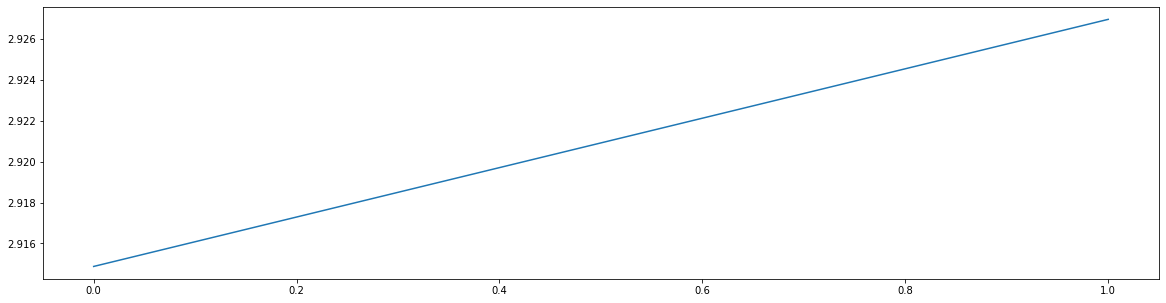

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_losses)
plt.show()

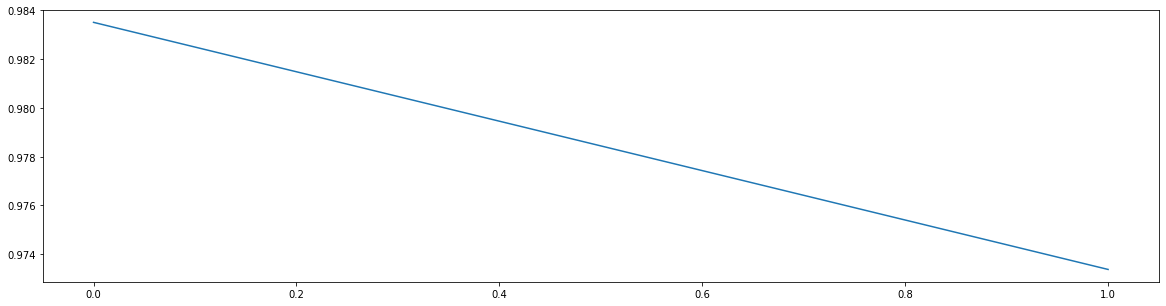

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_avg_cers)
plt.show()

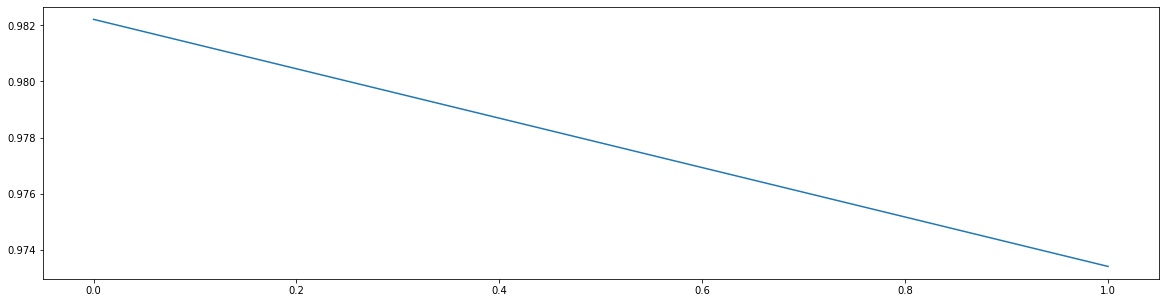

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(epochs), test_avg_wers)
plt.show()